# CSCA 5642 Introduction to Deep Learning Week 4 Homework

**Project topic**: This project intends to help the learner gain some basic natural language processing (NLP) techinque. NLP is a branch of artificial intelligence (AI) and computational linguistics that focuses on enabling computers to understand, interpret, and generate human language in a way that is both meaningful and useful. NLP involves many sub-domains such as text understanding, text generation, language modeling, etc. The primary task of this project - text classification - is generally considered to be under the umbrella of text understanding. Other common tasks in text understanding include named entity recognition, sentiment analysis, and semantic parsing.

## Preparation

In [43]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import random
import keras_tuner as kt


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
# from itertools import islice
import random

# text pre-processing
import nltk # natural language processing
from nltk.corpus import stopwords, wordnet # stop words
# from nltk.stem.snowball import SnowballStemmer # stemming
from nltk import pos_tag, word_tokenize # identify POS tag, required by lemmatizer
from nltk.stem import WordNetLemmatizer # lemmatization

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import layers, models, regularizers

from sklearn.metrics import confusion_matrix, classification_report

import keras_tuner as kt

# fix random seed for reproducibility
SEED = 0
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [32]:
project_root = '/home/lee/Documents/CSCA5642/week4/'
data_folder = os.path.join(project_root, 'nlp-getting-started')
model_folder = os.path.join(project_root, 'models')

train_orig = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_orig = pd.read_csv(os.path.join(data_folder, 'test.csv'))

## Description of the problem and data

**Data source**: https://www.kaggle.com/c/nlp-getting-started/

**Challenge problem**: This is a binary text classification problem. The input dataset contains Twitter tweets. Our task is to use deep learning techniques to identify if a certain tweet is describing a real disaster or otherwise. 

### Size

In [5]:
print(f"Training data size: {train_orig.size}")
print(f"Test data size: {test_orig.size}")

Training data size: 38065
Test data size: 13052


### Dimension

In [6]:
print(f"Training data shape: {train_orig.shape}")
print(f"Test data shape: {test_orig.shape}")

Training data shape: (7613, 5)
Test data shape: (3263, 4)


### Structure

In [7]:
print(f'Training data structure: \n{train_orig.head()}')
print(f'Test data structure: \n{test_orig.head()}')

Training data structure: 
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Test data structure: 
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor ki

## Exploratory Data Analysis (EDA)

### Inspect the Data

#### Class distribution

In [8]:
train_orig['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
train_orig['target'].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

The classes are well balanced. 

#### Word count

In [37]:
# Count the number of words in each sample
word_count = train_orig['text'].apply(lambda x: len(x.split()))
print('Distribution of word count')
word_count.describe()

Distribution of word count


count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text, dtype: float64

### Visualize the Data

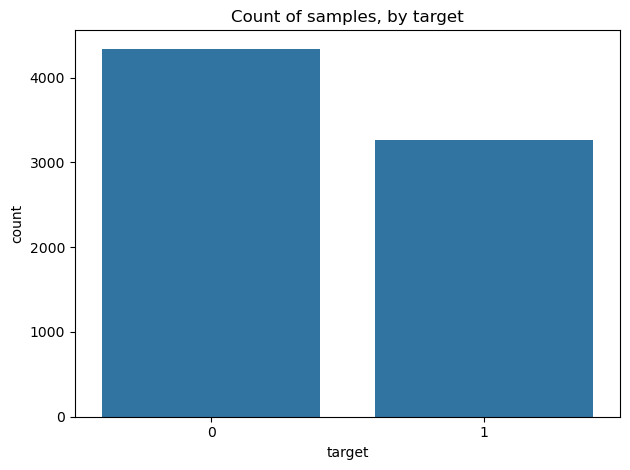

In [34]:
sns.countplot(train_orig, x='target')
# plt.xticks([0, 1])
plt.title('Count of samples, by target')
plt.tight_layout()
plt.show()

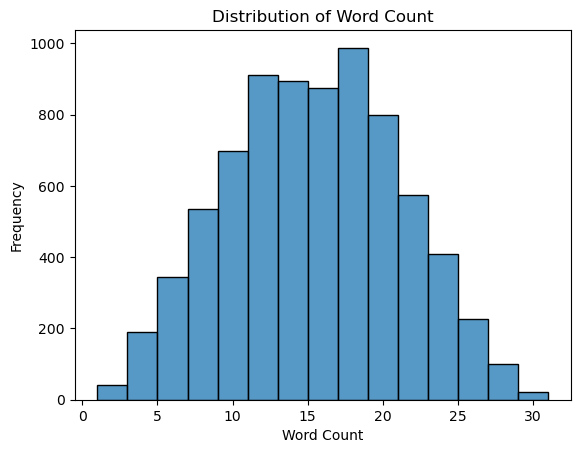

In [42]:
# Plot a histogram of the distribution of word count
sns.histplot(word_count, bins=15)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
# plt.grid(True)
plt.show()

## Analysis plan

Upon inspecting the data, we notice that many tweets contain hashtags; I will **remove the pound sign** from the tweets. Then I will **remove stop words**.

Stop words are a set of commonly used words in a language. Examples of stop words in English are "a", "the", "is", "are", etc. These words are so widely used that they carry very little useful information. Hence we remove stop words to reduce the number of tokens our algorithms need to process.

After removing the stop words, I will **tokenize** the tweet, and **pad/truncate** each tweet to a fixed length.

After processing the data we will fit a **RNN LSTM model** to perform this text classification. Then we will fit another RNN model with a **different architecture** and **compare their performances**. Then we will perform **hyperparameter tuning** on the selected model. 

Recurrent Neural Networks (RNNs) are commonly used in natural language processing tasks. RNNs are designed to handle sequential data by maintaining a hidden state that captures information about previous inputs in the sequence. They process input data step by step, updating their hidden state at each time step based on the current input and the previous hidden state. 

The LSTM model will include an **embedding** layer. This layer maps integer indices (representing words or tokens) to dense vectors of fixed size. It is a trainable layer that learns the word embeddings during the training process of the neural network, where the learned embeddings are initialized randomly (rather than with pre-trained embeddings such as Word2Vec, GloVe, FastText, etc.) and are adjusted during the training process.

With respect to embedding, alternatives to my train-from-scratch approach exist. Certain pre-trained word embedding techniques are popular in the industry of NLP. 
* Word2Vec. It learns word embeddings by training a neural network model on a large corpus of text data. There are two main architectures for training Word2Vec: Continuous Bag of Words (CBOW) and Skip-gram. CBOW predicts the target word based on its context words, while Skip-gram predicts context words based on the target word. Word2Vec embeddings are learned in such a way that words with similar meanings are closer together in the vector space.
* GloVe (Global Vectors for Word Representation). GloVe combines the advantages of global matrix factorization and local context window methods. It learns word embeddings by factorizing a global word-word co-occurrence matrix, which captures the frequency of word co-occurrences across the entire corpus. The resulting word embeddings encode semantic relationships between words based on their co-occurrence statistics.
* BERT (Bidirectional Encoder Representations from Transformers): BERT is based on the Transformer architecture, which is a powerful neural network architecture for sequence-to-sequence tasks. BERT learns contextualized word embeddings by pre-training on a large corpus using masked language modeling and next sentence prediction tasks. BERT embeddings capture not only word meanings but also their contextual nuances within sentences.

### Utilities

In [44]:
def summarize_history(model_history):
    """Plot the relationship between the number of epochs and the selected model performance metric.
    This plot can inform us whether we should train the model using more or fewer epochs. 
    """
    sns.lineplot(model_history.history['accuracy'], color='blue', label='train')
    sns.lineplot(model_history.history['val_accuracy'], color='green', label='validation')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')

hparams = {
    "batch_size": 16,
    "epochs": 10,
    "constraint_learning_rate": 0.01,
    "embedding_dim": 32,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 1000,
    "max_sequence_length": 20,
    "lstm_units": 32,
}

# download to working directory
nltk_download_dir = os.path.join(project_root, 'nltk_downloads')
nltk.download(['stopwords'], download_dir=nltk_download_dir)
nltk.data.path.append(nltk_download_dir)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lee/Documents/CSCA5642/week4/nltk_downloads...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Model Architecture

### Define the RNN model

My first RNN model contains one embedding layer to process the text and one LSTM layer. 

**Reason chossing this architecture**: Earlier in the Analysis plan section, I gave a description of RNN, which is often referred to as vanilla RNN or traditional RNN. Traditional RNNs suffer from the vanishing gradient problem, where gradients diminish as they are backpropagated through time, making it difficult for the network to learn long-range dependencies. This is why I use a LSTM model instead of vanilla RNN. LSTMs are a type of RNN specifically designed to address the vanishing gradient problem and capture long-range dependencies more effectively.

In [14]:
model_lstm = models.Sequential([
    layers.Embedding(input_dim=hparams["max_num_words"], output_dim=hparams["embedding_dim"], input_length=hparams["max_sequence_length"]),
    layers.LSTM(hparams["lstm_units"]),
    layers.Dense(units=1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-02-29 15:08:25.786040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 15:08:25.799093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 15:08:25.799193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Model comparison

My second RNN model still contains one embedding layer to process the text and one LSTM layer, but a batch normalization layer is added after the LSTM layer. 

**Reason chossing this architecture**: Batch normalization reduces the sensitivity of neural networks to the choice of initialization parameters. This makes it easier to initialize network weights and biases, leading to more stable training dynamics. It also acts as a form of regularization by adding noise to the activations of each layer during training. This noise helps to prevent overfitting and improve the generalization performance of the model.

In [15]:
# Modify the model architecture to add Batch Normalization
model_lstm_bn = models.Sequential()
model_lstm_bn.add(layers.Embedding(input_dim=hparams["max_num_words"], output_dim=hparams["embedding_dim"]))
model_lstm_bn.add(layers.LSTM(units=hparams["lstm_units"]))
model_lstm_bn.add(layers.BatchNormalization())
model_lstm_bn.add(layers.Dense(units=1, activation='sigmoid'))

# Compile the modified model
model_lstm_bn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Hyperparameter tuning

I will search for optimal number of units in the LSTM layer and learning rate in the winning model among the two. Refer to the Results and analysis section for the hyperparameter optimization process.

## Results and analysis

### Data cleaning

In [45]:
train_orig['removepound'] = train_orig['text'].str.replace('#', '')

In [46]:
# remove stop words
stop = stopwords.words('english')
train_orig['removestop'] = train_orig['removepound'].apply(lambda x: [item for item in x if item not in stop])

### Prepare training data

In [47]:
# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(train_orig['removestop'], train_orig['target'], test_size=0.2, random_state=42)

# Tokenize the texts
tokenizer = Tokenizer(num_words=hparams["max_num_words"])
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to have the same length
train_data = pad_sequences(train_sequences, maxlen=hparams["max_sequence_length"])
test_data = pad_sequences(test_sequences, maxlen=hparams["max_sequence_length"])

### Train the model

In [17]:
history_lstm = model_lstm.fit(train_data, train_labels, epochs=hparams["epochs"], batch_size=hparams["batch_size"], validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model_lstm.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_acc}')

Epoch 1/10


2024-02-29 15:08:37.443329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-29 15:08:37.477667: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe968565050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 15:08:37.477682: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-02-29 15:08:37.480160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-29 15:08:37.488651: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
 

305/305 [==============================] - 5s 14ms/step - loss: 0.5559 - accuracy: 0.7022 - val_loss: 0.4835 - val_accuracy: 0.7660
Epoch 2/10
305/305 [==============================] - 1s 3ms/step - loss: 0.4068 - accuracy: 0.8212 - val_loss: 0.4600 - val_accuracy: 0.7890
Epoch 3/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3698 - accuracy: 0.8368 - val_loss: 0.4799 - val_accuracy: 0.7865
Epoch 4/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3542 - accuracy: 0.8459 - val_loss: 0.5048 - val_accuracy: 0.7833
Epoch 5/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3393 - accuracy: 0.8553 - val_loss: 0.5043 - val_accuracy: 0.7898
Epoch 6/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3258 - accuracy: 0.8580 - val_loss: 0.5081 - val_accuracy: 0.7931
Epoch 7/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3088 - accuracy: 0.8744 - val_loss: 0.5696 - val_accuracy: 0.7791
Epoch 8/10
305/3

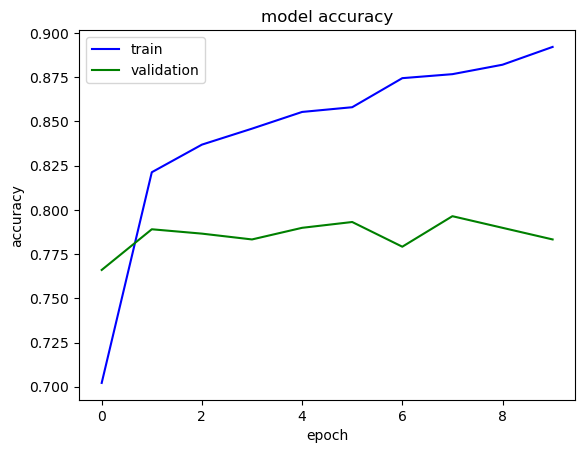

In [19]:
summarize_history(history_lstm)

### Train the other RNN model

In [18]:
history_lstm_bn = model_lstm_bn.fit(train_data, train_labels, epochs=hparams["epochs"], batch_size=hparams["batch_size"], validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model_lstm_bn.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_acc}')

Epoch 1/10
305/305 [==============================] - 5s 12ms/step - loss: 0.5338 - accuracy: 0.7334 - val_loss: 0.5899 - val_accuracy: 0.7365
Epoch 2/10
305/305 [==============================] - 1s 3ms/step - loss: 0.4270 - accuracy: 0.8091 - val_loss: 0.5103 - val_accuracy: 0.7734
Epoch 3/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3808 - accuracy: 0.8325 - val_loss: 0.5488 - val_accuracy: 0.7479
Epoch 4/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3429 - accuracy: 0.8567 - val_loss: 0.5439 - val_accuracy: 0.7644
Epoch 5/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3102 - accuracy: 0.8684 - val_loss: 0.9111 - val_accuracy: 0.7447
Epoch 6/10
305/305 [==============================] - 1s 2ms/step - loss: 0.2898 - accuracy: 0.8732 - val_loss: 0.6884 - val_accuracy: 0.7455
Epoch 7/10
305/305 [==============================] - 1s 2ms/step - loss: 0.2716 - accuracy: 0.8834 - val_loss: 0.7087 - val_accuracy: 0.7586
Epoch

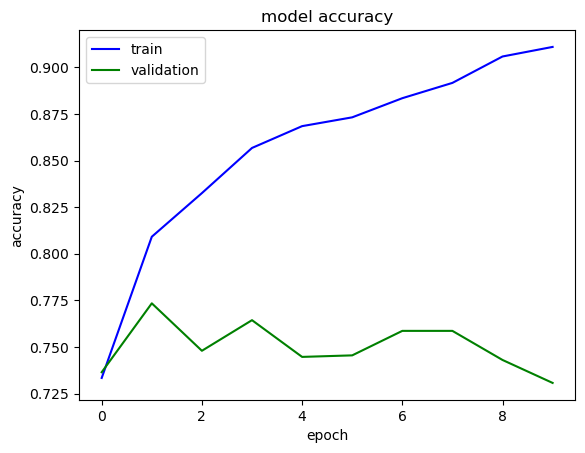

In [20]:
summarize_history(history_lstm_bn)

We will proceed with the model without the BatchNormalization layer. Next we will optimize it via hyperparameter tuning.

### Hyperparameter optimization

In [21]:
def model_builder(hp):

    model = models.Sequential()
    model.add(layers.Embedding(input_dim=hparams["max_num_words"], output_dim=hparams["embedding_dim"], input_length=hparams["max_sequence_length"]))
    hp_units = hp.Int('units', min_value=16, max_value=128, step=16)
    model.add(layers.LSTM(hp_units))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])

    return model

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=hparams["epochs"],
                     factor=3,
                     )

In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_data, train_labels, epochs=hparams["epochs"], validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#### Conclusion for hyperparameter tuning

In [48]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the LSTM
layer is 16 and the optimal learning rate for the optimizer
is 0.001.



In [25]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_tuned = tuner.hypermodel.build(best_hps)
history_tuned = model_tuned.fit(train_data, train_labels, epochs=hparams["epochs"], validation_split=0.2)

Epoch 1/10
153/153 [==============================] - 4s 23ms/step - loss: 0.6124 - accuracy: 0.6626 - val_loss: 0.5337 - val_accuracy: 0.7504
Epoch 2/10
153/153 [==============================] - 1s 5ms/step - loss: 0.4409 - accuracy: 0.8081 - val_loss: 0.4575 - val_accuracy: 0.7915
Epoch 3/10
153/153 [==============================] - 1s 3ms/step - loss: 0.3794 - accuracy: 0.8417 - val_loss: 0.4771 - val_accuracy: 0.7742
Epoch 4/10
153/153 [==============================] - 0s 2ms/step - loss: 0.3592 - accuracy: 0.8491 - val_loss: 0.4861 - val_accuracy: 0.7906
Epoch 5/10
153/153 [==============================] - 0s 2ms/step - loss: 0.3453 - accuracy: 0.8573 - val_loss: 0.4821 - val_accuracy: 0.7857
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.3352 - accuracy: 0.8619 - val_loss: 0.4968 - val_accuracy: 0.7898
Epoch 7/10
153/153 [==============================] - 0s 2ms/step - loss: 0.3206 - accuracy: 0.8719 - val_loss: 0.5064 - val_accuracy: 0.7874
Epoch

In [26]:
eval_result = model_tuned.evaluate(test_data, test_labels)
print("[test loss, test accuracy]:", eval_result)

48/48 [==============================] - 0s 790us/step - loss: 0.5579 - accuracy: 0.7702
[test loss, test accuracy]: [0.5579403042793274, 0.770190417766571]


In [33]:
model_tuned.save(os.path.join(model_folder, 'text_classifier_model.keras'))

### Summary

| Algorithm | Accuracy (in test data) |
| --- | ----------- |
| RNN model with 1 LSTM layer | 0.7676 |
| RNN model with 1 LSTM and 1 BatchNormalization layers | 0.7163 |
| RNN model with 1 LSTM layer and hyperparameter optimization | 0.7702 |

### Analysis

**What improved model performance**: Hyperparameter tuning, but very slightly. 

**What did not help improve model performance**: Adding the batch norm layer. **Why**: The model may not have a sufficiently complex architecture or model depth. Instead of regularization, it may be more promising to increase the number of layers in the RNN architecture to capture more complex patterns in the data.

**Troubleshooting**: I have plotted the relationship between the number of epochs and model accuracy. That trajectory of the model without the batch norm layer pairs shows that training the model for more epochs is not likely to continue improve the model performance. 

## Conclusion

**Results**: The RNN model with 1 LSTM layer and hyperparameter optimization but without any BatchNormalization layers is my best performing model, with an accuracy of 0.7702 in test data.

**Learning and takeaways**: Hyperparameter tuning has the potential to improve the model.

**Analysis of what did not help**: Without enough RNN (including LSTM, GRU, bidirectional, etc.) layers to capture the features from the input data, making adjustments to other hyperparameters may not be effective. 

**Improvements to try in the future**:
* add more fully connected layers before the output
* add more LSTM layers to the model
* add other types of RNN layers, such as Gated recurrent units (GRUs)
* tune other hyperparameters, such as the ones in the Embedding layer
* preprocess the text data in more depth, such as performing lemmatization

In [27]:
submission_texts = test_orig['text'].str.replace('#', '')
submission_sequences = tokenizer.texts_to_sequences(submission_texts)
submission_data = pad_sequences(submission_sequences, maxlen=hparams["max_sequence_length"])

In [28]:
test_orig['pred_score'] = model_tuned.predict(submission_data)

102/102 [==============================] - 0s 494us/step


In [29]:
test_orig['target'] = np.where(test_orig['pred_score'] >= 0.5, 1, 0)

In [30]:
test_orig[['id', 'target']].to_csv(os.path.join(project_root, 'submit.csv'), index = False)

**GitHub repo URL**: https://github.com/EnergizeStatistics/csca5642week4